Using Athena version 20.7.3.8, on /afs/cern.ch/user/m/mazhang/eos/atlas/user/m/mazhang/Data/xAOD/VertexingXAODttbar/XAOD.pileupTruth.ttbar.pool.root.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
datafile = "../Data/TrackAssociation/20160502.txt"
data = np.loadtxt(datafile, delimiter="\t", skiprows=1) #first row is branch names

In [2]:
branch_names = open(datafile).readline().rstrip().split(",")
branch_names = [c.strip() for c in branch_names]

In [3]:
y = np.array([row[branch_names.index("correctVtx")] for row in data])
X = np.delete(data, branch_names.index("correctVtx"), 1)
branch_names.pop(branch_names.index("correctVtx"));
X = np.delete(X, branch_names.index("truVtxX"), 1)
branch_names.pop(branch_names.index("truVtxX"));
X = np.delete(X, branch_names.index("truVtxY"), 1)
branch_names.pop(branch_names.index("truVtxY"));
X = np.delete(X, branch_names.index("truVtxZ"), 1)
branch_names.pop(branch_names.index("truVtxZ"));

In [4]:
from sklearn.cross_validation import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=492)

In [39]:
from sknn.mlp import Regressor, Layer

def train(learning_rate=0.02, iterations=20, neurons=4, weight=1, m=X_train.shape[0]):

    nn = Regressor(layers=[Layer("Tanh", units=10), Layer("Tanh", units=10), Layer("Tanh")],
                   learning_rate=learning_rate, n_iter=iterations)
    if weight != 1:
        weight_train = np.ones(m)
        weight_train[y_train[0:m] == 0] = weight #weigh incorrect tracks
        nn.fit(X_train[0:m][:], y_train[0:m][:], weight_train)
    else:
        nn.fit(X_train[0:m][:], y_train[0:m][:])
    return nn

In [43]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,precision_recall_curve
import matplotlib.patches as mpatches

def plotNNTest(**kwarg):

    m = [10,30,100,300,1000,3000,10000,30000,100000]
    trainAccuracies = []
    valAccuracies = []
    trainPrecisions = []
    valPrecisions = []
    trainRecalls = []
    valRecalls = []

    for n in m:

        nn = train(**kwarg, m=n)

        predictX = np.round(nn.predict(X_train[0:n][:]))
        predictXval = np.round(nn.predict(X_val))
        
        trainAccuracy = accuracy_score(y_train[0:n][:], predictX)
        valAccuracy = accuracy_score(y_val, predictXval)
        trainPrecision = precision_score(y_train[0:n][:], predictX)
        valPrecision = precision_score(y_val, predictXval)
        trainRecall = recall_score(y_train[0:n][:], predictX)
        valRecall = recall_score(y_val, predictXval)

        trainAccuracies.append(trainAccuracy)
        valAccuracies.append(valAccuracy)
        trainPrecisions.append(trainPrecision)
        valPrecisions.append(valPrecision)
        trainRecalls.append(trainRecall)
        valRecalls.append(valRecall)

    plt.semilogx(m,trainRecalls,'b-')
    plt.semilogx(m,valRecalls,'r-')
    plt.xlabel("Training Samples")
    plt.ylabel("Efficiency")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()
    
    plt.semilogx(m,[1-i for i in trainPrecisions],'b-')
    plt.semilogx(m,[1-i for i in valPrecisions],'r-')
    plt.xlabel("Training Samples")
    plt.ylabel("Mismatch Rate")
    trainLine = mpatches.Patch(color='blue', label='training')
    valLine = mpatches.Patch(color='red', label='validation')
    plt.legend(handles=[trainLine,valLine], loc='lower right')
    plt.show()

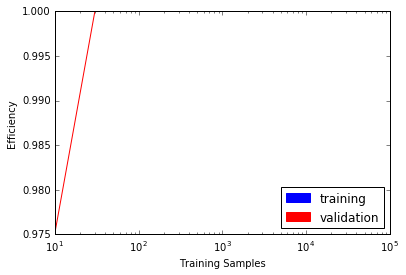

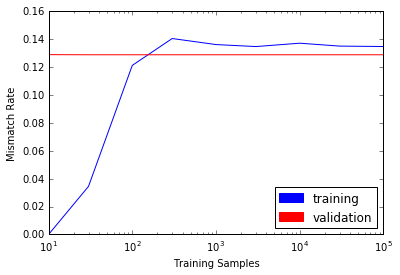

In [22]:
plotNNTest(neurons=4)

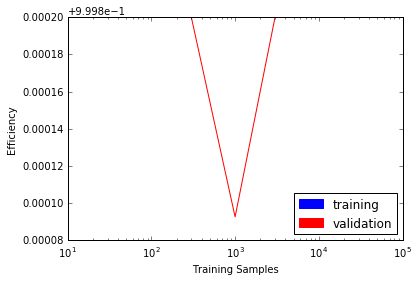

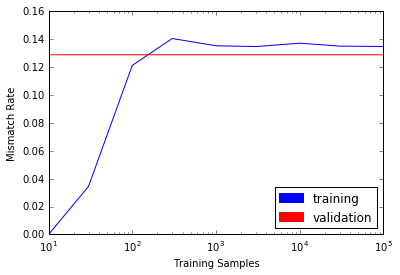

In [25]:
plotNNTest(neurons=6)

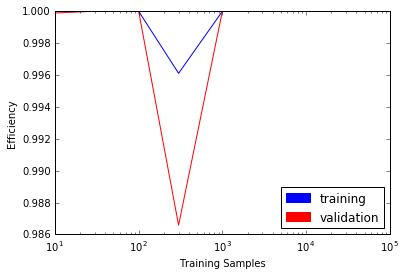

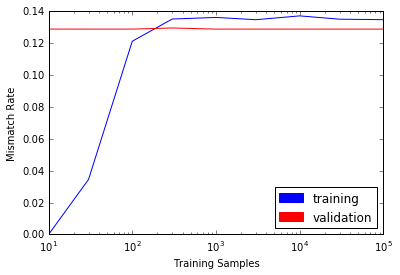

In [26]:
plotNNTest(neurons=8)

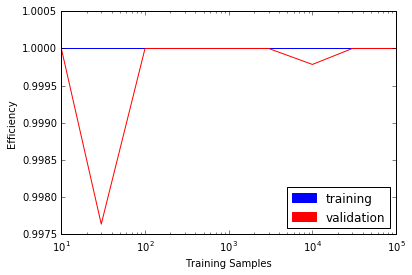

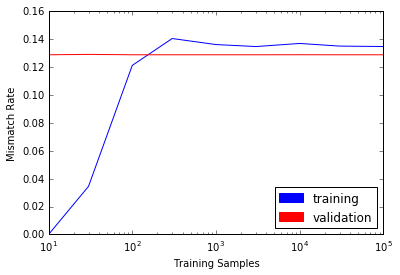

In [27]:
plotNNTest(neurons=10)

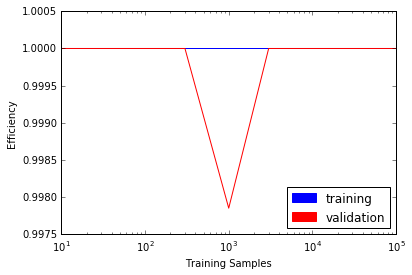

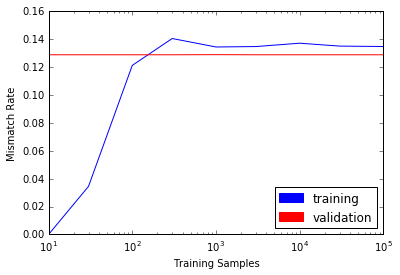

In [33]:
plotNNTest(neurons=10, iterations=40)

Weight 5:


/Users/mattzhang/py3_kernel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100000 but corresponding boolean dimension is 32091


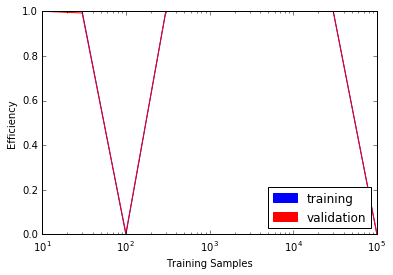

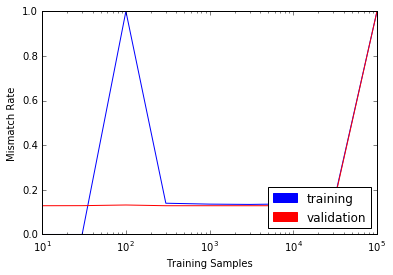

Weight 6:


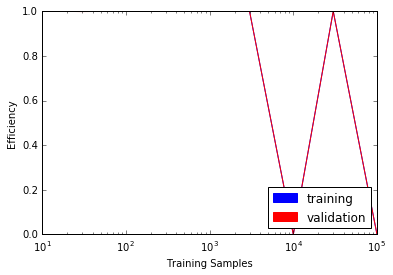

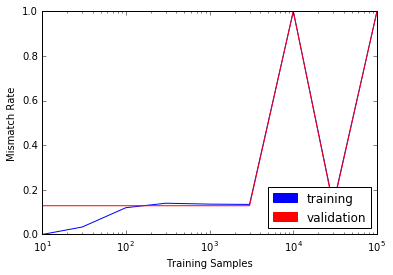

Weight 7:


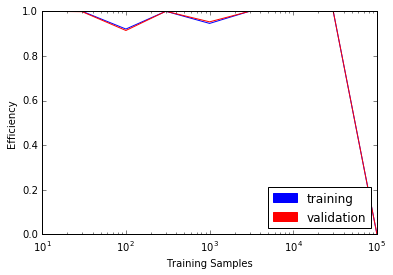

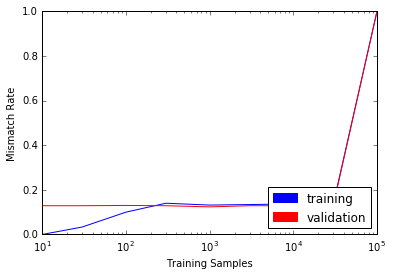

Weight 8:


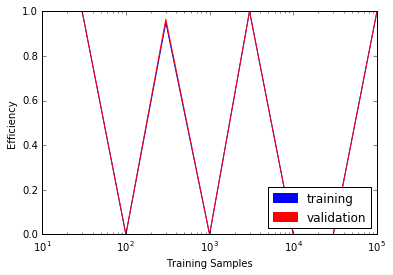

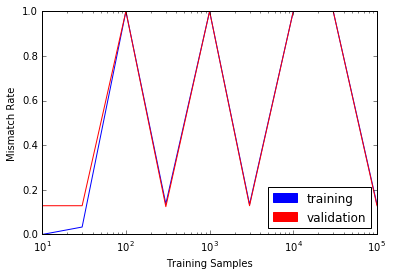

In [44]:
for i in range(5,9):
    print("Weight %d:" % i)
    plotNNTest(neurons=10, iterations=20, weight=i)

/Users/mattzhang/py3_kernel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/mattzhang/py3_kernel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of s

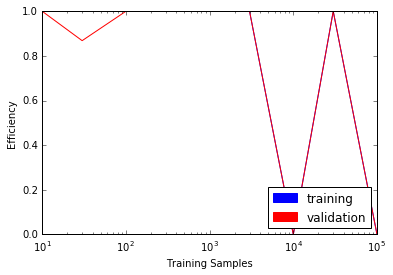

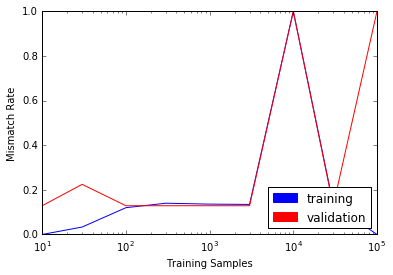

In [46]:
plotNNTest(neurons=10, iterations=100, learning_rate=0.1, weight=8)

In [ ]:
import pickle

nn = train()
pickle.dump(nn, open('trainedNN', 'wb'))

y_predicted = np.round(nn.predict(X_test).flatten())
correctPrediction = 1*np.equal(y_predicted, y_test)
actualTrue = np.array(y_test==1)
actualFalse = np.array(y_test==0)
predictedTrue = np.array(y_predicted==1)
predictedFalse = np.array(y_predicted==0)

print("PT = predicted true; AF = actual false")
print("PT & AT:", sum(np.multiply(predictedTrue, actualTrue)))
print("PF & AT:", sum(np.multiply(predictedFalse, actualTrue)))
print("PT & AF:", sum(np.multiply(predictedTrue, actualFalse)))
print("PF & AF:", sum(np.multiply(predictedFalse, actualFalse)))

eta = X_test[:,branch_names.index("eta")]
nbins = 10

#tracks % identified correctly
n, _ = np.histogram(eta, bins=nbins)
sy, _ = np.histogram(eta, bins=nbins, weights=correctPrediction)
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Tracks Identified Correctly")
plt.show()
print(mean)

#efficiency = % identified as true out of all actual true
n, _ = np.histogram(eta[actualTrue], bins=nbins)
sy, _ = np.histogram(eta[actualTrue], bins=nbins, weights=1*predictedTrue[actualTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Efficiency")
plt.show()
print(mean)

#mismatch rate = % actual false out of those identified as true
n, _ = np.histogram(eta[predictedTrue], bins=nbins)
sy, _ = np.histogram(eta[predictedTrue], bins=nbins, weights=1*actualFalse[predictedTrue])
mean = sy / n
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=0, fmt='r-')
plt.xlabel("Normalized eta")
plt.ylabel("Mismatch Rate")
plt.show()
print(mean)

## END

N_iter: 20 , Efficiency: 0.956969631935 , Mismatch: 0.0902784861777
N_iter: 30 , Efficiency: 0.978323854491 , Mismatch: 0.103627961852
N_iter: 40 , Efficiency: 0.975319240262 , Mismatch: 0.0981345505061
N_iter: 50 , Efficiency: 0.979718853954 , Mismatch: 0.100492610837


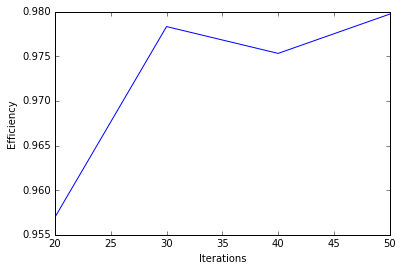

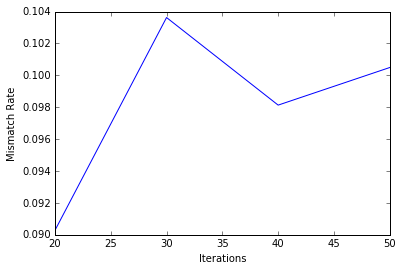

In [27]:
from sklearn.metrics import precision_score, recall_score

n_iter = range(20,60,10)
efficiencies = []
mismatches = []

for n in n_iter:

    nn = train(0.02, n)
    y_predicted = np.round(nn.predict(X_val))

    precisionScore = precision_score(y_val, y_predicted)
    recallScore = recall_score(y_val, y_predicted)
    efficiencies.append(recallScore)
    mismatches.append(1-precisionScore)
    print("N_iter:", n, ", Efficiency:", recallScore, ", Mismatch:", 1-precisionScore)
    
plt.plot(n_iter,efficiencies)
plt.xlabel("Iterations")
plt.ylabel("Efficiency")
plt.show()

plt.plot(n_iter,mismatches)
plt.xlabel("Iterations")
plt.ylabel("Mismatch Rate")
plt.show()

PT = predicted true; AF = actual false
PT & AT: 9161
PF & AT: 138
PT & AF: 1069
PF & AF: 329


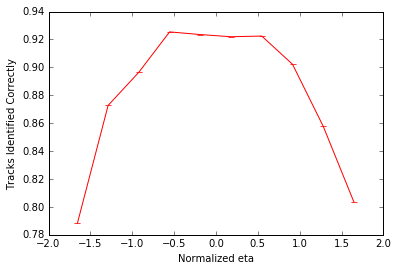

[ 0.78826237  0.87274549  0.89652096  0.92546064  0.92353952  0.9219917
  0.92246696  0.90223695  0.85773196  0.80335731]


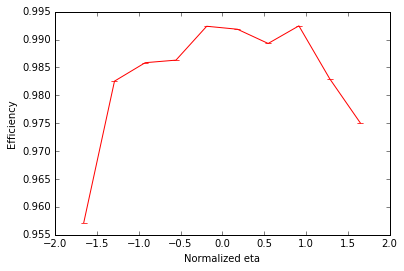

[ 0.95718654  0.98253783  0.98584429  0.98630137  0.99237369  0.99184044
  0.98928919  0.9924457   0.98298906  0.975039  ]


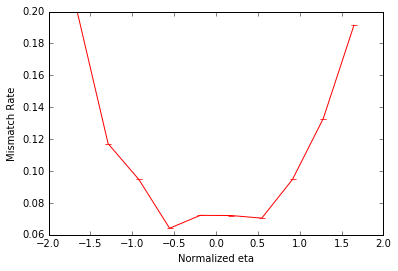

[ 0.19948849  0.11715481  0.09470752  0.06412478  0.07219251  0.072095
  0.07044831  0.09474591  0.13290461  0.19146184]
